# Promoter footprints

In [113]:
using Pkg, Revise

Pkg.activate("../../../.")

using wgregseq, CSV, DataFrames, CairoMakie, Statistics, BioSequences, StatsBase
wgregseq.plotting_style.default_makie!()

  Activating project at `~/git/1000_genes_ecoli`


In [66]:
df_sites = CSV.read("known_sites.txt", DataFrame)
color_dict = Dict("rep" => :tomato, "act" => "#b0dd16")

int_dict = Dict(1 => "A", 2 => "C", 3 => "G", 4 => "T")

wt_regseq = CSV.read("../../../data/wtsequences_regseq.csv", DataFrame)


Row,Column1,name,start_site,rev,geneseq,ssdiff,offset
,Int64,String15,Float64,String3,String,Float64?,Float64?
1,0,fdoH,4.08587e6,rev,CATTATGGTATTCTGTTACAAACCCTTCCTGGATGGAGGGAAATTGAGCCAATTCTGGACCTTTGCGGCCCCTTCCGCAAAGAAAAATAACTCCCACTCCCTGCACACGCAGCAAGCGAATGTAAATGGGACGTGACAATGTCGAAACAAGGAGCAATCC,0.0,0.0
2,3,sdaB,2.92804e6,fwd,TACATATATTGCGCGCCCCGGAAGAAGTCAGATGTCGTTTAATGGGCAAATATTGCCCTTAAATTCTCTTTTACTTTTGATTTACAGAGTAAAGCGTTGGGATAATCTATCTTCCAAGTAGATTATTGTATTTGAGATCAAGATCACTGATAGATACATA,0.0,0.0
3,6,thiM,2.18545e6,rev,TCTGGATGTCGTTCTGAAGGTGCTGGATTCATATATCAAATAATTTATTAACGCGATTGTAAAACTGCCGTTTTTCCTCGTTTACAACGCGTGCGCTGGACATTACCATCCTCCTCTGCGATTTATCATCGCAACCAAACGACTCGGGGTGCCCTTCTGC,0.0,0.0
4,7,yedJ,2.03345e6,rev,TTTTTCCTGTATTCACTGCCGTTGCGCAAAATTTATCTATTTGTTCAAAAAATGATTGAGTCTTGACTGGCTCATCCAATGTGGAAAAATGTGACTTTTATCACATAATAGTACTAAGTCTGAATTTTCCGGGTTATCTCAAAATGGAATACGGTTCGAC,0.0,0.0
5,9,ykgE,321511.0,fwd,TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAGATTATCATTTGTCATACAAATGAGGGGTGGTATGTTGCTAGCCAATTAAAAAAGAACGCCATATTTATTGATGATTGATCCCCCGG,0.0,0.0
6,11,sdiA,1.99687e6,rev,GCATAACTCATTAATAACATAAGAGAATGCGATGGCTTGCAAAAGTAATTCATTGCCTGAATAATATAAATTATATATAAATCTTATTTATGTGATAGTTTGAATTATCATTATAAATGATACTCACTCTCAGGGGCGTTGCGGTTTACTATGCAGGATA,10.0,-10.0
7,12,yqhC,3.15526e6,rev,GTGTGCAGATTAAAGTTGTTCATTACTTGCTCCCTTTGCTGGGCCAATATGAGGGCAGAGAACGATCTGCCTGATGTTTTTCATTGTGATCGCCAGCGCCCTGGCTCTCAATGCTCATTTCTGCCAATGTCTTGCCTATTTCTCCAGAGTGCTGGAGAAA,-1.0,1.0
8,15,yicI,3.83666e6,rev,CCGAATTTATATATTAATTATAGTAAGGCAATGAGCTATTTTTGATAGTAAAAATAAAACAAGTTGATTTGATATATTAAATGAACAAATTAATCTTGATGGCAGTCTGATTATTGGTGAAGTTTATAGTCAGTTTTTTTCGCCAGCGGTTAAAGAAATA,0.0,0.0
9,17,ybjT,909320.0,rev,AAACTCGAACAGGCCAAAGGTTTCAGCCTGTATATGCTGCGCGCAATCATCAGCGGACGCGGTGATGAAGTGATCGAACTGGCGAAAACAAACTGGCTAAGGTAAAAAGGGTGGCATTTCCCGTCATAATAAGGACATGCCATGATTGATTTACGCAGTG,0.0,0.0


In [83]:
function eval_prom(prom, d=0)
    gc_dict = Dict("LB" => "LB", "Gluc"=> "M9", "XyAr" => "xylara")
    prom_dict = Dict(
        "rspA" => "rspA",
        "znuC" => "znuCB",
        "xylA" => "xylA",
        "xylF" => "xylF",
        "araC" => "araC",
        "ompR" => "ompR",
        "ftsK" => "ftsK",
        "dgoR" => "dgoR"
        )
    f = Figure(backgroundcolor = RGBf(0.98, 0.98, 0.98),
    resolution = (4000, 1000))
    for (i, GC) in enumerate(["LB", "Gluc", "XyAr", "Etoh"])
        ga = f[i, 1] = GridLayout()
        gb = f[i, 2] = GridLayout()
        gc = f[i, 3] = GridLayout()
        gd = f[i, 4] = GridLayout()
        ge = f[i, 5] = GridLayout()
        gf = f[i, 6] = GridLayout()
        
        gaa = ga[1, 1] = GridLayout()
        gab = ga[1, 2] = GridLayout()
        gac = ga[1, 3] = GridLayout()
    

        df = CSV.read("../../../data/$(GC)_barcodes.csv", DataFrame)
        df = df[df.name .== prom, :]
        df = df[df.ct_1 .< 5*10^3, :]
        pfm = PFM(LongDNA{4}.(df.promoter))
        wt_seq = [int_dict[x[1]] for x in argmax(pfm, dims=1) |> vec]
        
        x = log10.((df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
        ax2 = Axis(gab[1, 1], xlabel="log10 counts", ylabel="ECDF")
        x1 = log10.(df.ct_1)
        x0 = log10.(df.ct_0)

        lines!(ax2, sort(x1), 1/length(x1):1/length(x1):1, label="RNA")
        lines!(ax2, sort(x0), 1/length(x0):1/length(x0):1, label="DNA")
        ylims!(0, 1.1)
        xlims!(-0.1, 5)
        axislegend(ax2, position=:rb)

        ax = Axis(gac[1, 1], xlabel="log10 relative counts", ylabel="ECDF")
        lines!(ax, sort(x), 1/length(x):1/length(x):1)

        x = wgregseq.analysis_utils.expression_shift(df)
        ax = Axis(
            gb[1, 1], 
            xlabel="position", 
            ylabel="expression shift", 
            xticks=(-115+d:44-d, wt_seq[1+d:160-d]), 
            xticklabelsize=5, 
            xgridwidth=0.2,
            xminorgridwidth=0,
            xticksize=3
        )
        barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        draw_sites(ax, prom, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        

        x = wgregseq.analysis_utils.mutual_information_bases(df)
        ax = Axis(
            gc[1, 1], 
            xlabel="position", 
            ylabel="mutual information[bits]",
            xticks=(-115+d:44-d, wt_seq[1+d:160-d]), 
            xticklabelsize=5, 
            xgridwidth=0.2,
            xminorgridwidth=0,
            xticksize=3
        )
        barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        draw_sites(ax, prom, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        
        x = wgregseq.analysis_utils.mutual_information_mutation(df)
        ax = Axis(
            gd[1, 1], 
            xlabel="position", 
            ylabel="mutual information[bits]",
            xticks=(-115+d:44-d, wt_seq[1+d:160-d]), 
            xticklabelsize=5, 
            xgridwidth=0.2,
            xminorgridwidth=0,
            xticksize=3
        )
        barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        draw_sites(ax, prom, [mean(x[i-d:i+d]) for i in 1+d:160-d])

        mcmc = CSV.read("footprints/$(GC)_$(prom)_mcmc_mpathic.csv", DataFrame)
        mcmc = Array(mcmc[:, [:val_A, :val_C, :val_G, :val_T]])
        if typeof(mcmc) == Matrix{Missing}
            continue
        end
        prob_mat = exp.(mcmc) ./ sum(exp.(mcmc), dims=2)
        x = sum(prob_mat .* log2.(prob_mat ./ 0.25), dims=2) |> vec
        ax = Axis(
            ge[1, 1], 
            xlabel="position", 
            ylabel="relative entropy[bits]",
            xticks=(-115+d:44-d, wt_seq[1+d:160-d]), 
            xticklabelsize=5, 
            xgridwidth=0.2,
            xminorgridwidth=0,
            xticksize=3
        )
        barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        draw_sites(ax, prom, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        
        if GC != "Etoh"
            if prom[1:4] ∉ collect(keys(prom_dict))
                continue
            elseif ~isfile("regseq_footprints/information_footprints/$(prom_dict[prom[1:4]])$(gc_dict[GC])datasetinfofootprint.txt")
                continue
            end
                
            reg_df = CSV.read(
                "regseq_footprints/information_footprints/$(prom_dict[prom[1:4]])$(gc_dict[GC])datasetinfofootprint.txt", 
                DataFrame,
                ignorerepeated=true,
                delim=" "
            )
            x = abs.(reg_df.info)
            seq = wt_regseq[wt_regseq.name .== prom_dict[prom[1:4]], :geneseq][1] |> collect .|> string
            ax = Axis(
                gf[1, 1], 
                xlabel="position", 
                ylabel="relative entropy[bits]",
                xticks=(-115+d:44-d, seq[1+d:160-d]), 
                xticklabelsize=5, 
                xgridwidth=0.2,
                xminorgridwidth=0,
                xticksize=3
            )
            
            barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
            #draw_sites(ax, prom, [mean(x[i-d:i+d]) for i in 1+d:160-d])
        end

        Label(gaa[1, 1, Top()], "Promoter: $(prom)\nGrowth condition: $(GC)", valign = :bottom,
        padding = (0, 0, -100, 0))
        if i == 1
            Label(ga[1, 1:2, Top()], "DNA/RNA counts", valign = :bottom,
            padding = (0, 0, 5, 0))
            Label(gb[1, 1, Top()], "Expression Shift", valign = :bottom,
            padding = (0, 0, 5, 0))
            Label(gc[1, 1, Top()], "Mutual Information with Base identity", valign = :bottom,
            padding = (0, 0, 5, 0))
            Label(gd[1, 1, Top()], "Mutual Information with Mutation identity", valign = :bottom,
            padding = (0, 0, 5, 0))
            Label(ge[1, 1, Top()], "Additive Model MCMC", valign = :bottom,
            padding = (0, 0, 5, 0))
            Label(gf[1, 1, Top()], "RegSeq Footprints", valign = :bottom,
            padding = (0, 0, 5, 0))
        end
    end
    return f
end

eval_prom (generic function with 2 methods)

In [84]:
function draw_sites(ax, prom, y)
    sites = df_sites[df_sites.promoter .== prom, :]
    # Draw -10 region
    fill_between!(
                ax, 
                [-16, -10], 
                [min(0, minimum(y)), min(0, minimum(y))], 
                [maximum(y), maximum(y)],
                color=("#95d0fc", 0.4)
            )
    # Draw -35 region
    fill_between!(
                ax, 
                [-42, -35], 
                [min(0, minimum(y)), min(0, minimum(y))], 
                [maximum(y), maximum(y)],
                color=("#95d0fc", 0.4)
            )
    if nrow(sites) > 0
        for i in 1:nrow(sites)
            fill_between!(
                ax, 
                [sites[i, :start], sites[i, :end]], 
                [min(0, minimum(y)), min(0, minimum(y))], 
                [maximum(y), maximum(y)],
                color=(color_dict[sites[i, :type]], 0.1)
            )
        end
    end
    return ax
end

draw_sites (generic function with 1 method)

In [92]:
for prom in [
        "rspAp",
        "znuCp",
        "xylAp",
        "xylFp",
        "dicCp",
        "relBp",
        "ftsKp1",
        "ftsKp2",
        "lacIp",
        "marRp",
        "dgoRp",
        "ompRp1",
        "ompRp2",
        "ompRp3",
        "ompRp4",
        "araCp"
    ]
    f = eval_prom(prom, 1)
    save("outputs/$(prom).pdf", f)
end 

LoadError: BoundsError: attempt to access 0-element Vector{String} at index [1]

## Whats up with rspA

repressor site at -35 and activator site at -60

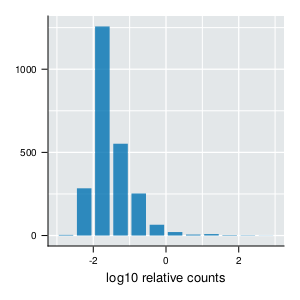

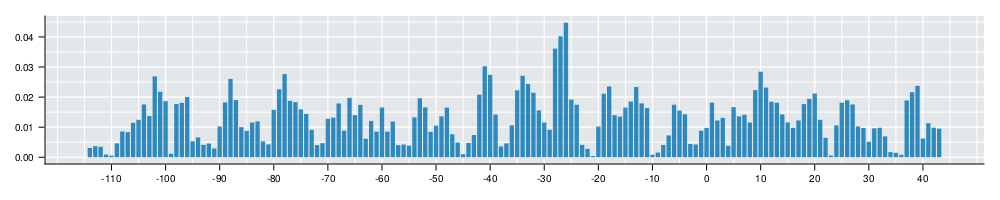

In [180]:
df = CSV.read("../../../data/Gluc_barcodes.csv", DataFrame)
df = df[df.name .== "rspAp", :]

insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
f = fit(Histogram, log10.(df.relative_counts))#, nbins=nbins)

fig = Figure(resolution=(300, 300))
ax = Axis(fig[1, 1], xlabel="log10 relative counts")
barplot!(ax, collect(f.edges[1][1:end-1].+ (f.edges[1][2]-f.edges[1][1])/2), f.weights)
save("20221104_relative_counts_no_filter_rspA.pdf", fig)
display(fig)
x = wgregseq.analysis_utils.mutual_information_mutation(df)
fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1], xticks=(-110:10:40))
d=1
barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
save("20221104_footprint_no_filter_rspA.pdf", fig)
fig

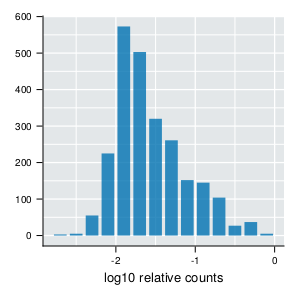

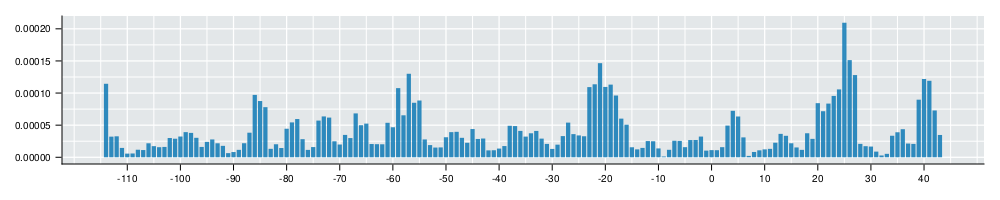

In [181]:
df = CSV.read("../../../data/Gluc_barcodes.csv", DataFrame)
df = df[df.name .== "rspAp", :]
insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
df = df[log.(df.relative_counts) .< 0, :]

f = fit(Histogram, log10.(df.relative_counts))#, nbins=nbins)

fig = Figure(resolution=(300, 300))
ax = Axis(fig[1, 1], xlabel="log10 relative counts")
barplot!(ax, collect(f.edges[1][1:end-1].+ (f.edges[1][2]-f.edges[1][1])/2), f.weights)
display(fig)
save("20221104_relative_counts_lowpass_rspA.pdf", fig)
x = wgregseq.analysis_utils.mutual_information_mutation(df)
fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1], xticks=(-110:10:40))
d=1
barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
save("20221104_footprint_lowpass_rspA.pdf", fig)
fig

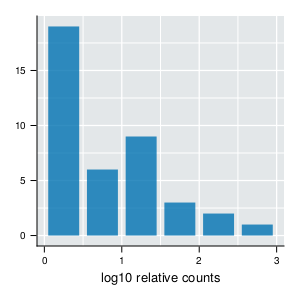

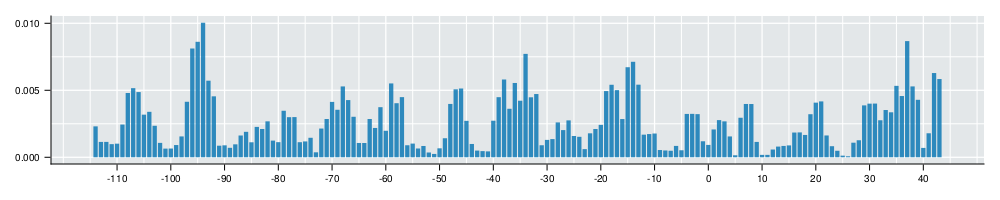

In [182]:
df = CSV.read("../../../data/Gluc_barcodes.csv", DataFrame)
df = df[df.name .== "rspAp", :]
insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
df = df[log.(df.relative_counts) .> 0, :]

f = fit(Histogram, log10.(df.relative_counts))#, nbins=nbins)

fig = Figure(resolution=(300, 300))
ax = Axis(fig[1, 1], xlabel="log10 relative counts")
barplot!(ax, collect(f.edges[1][1:end-1].+ (f.edges[1][2]-f.edges[1][1])/2), f.weights)
display(fig)
save("20221104_relative_counts_highpass_rspA.pdf", fig)
x = wgregseq.analysis_utils.mutual_information_mutation(df)
fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1], xticks=(-110:10:40))
d=1
barplot!(ax, -115+d:44-d, [mean(x[i-d:i+d]) for i in 1+d:160-d])
save("20221104_footprint_highpass_rspA.pdf", fig)
fig

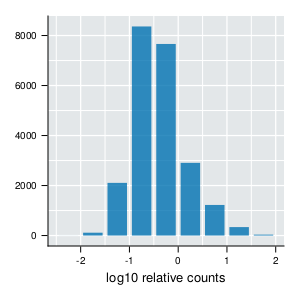

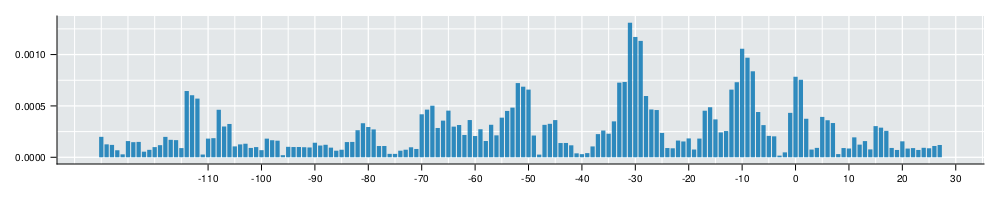

In [183]:
df_reg_DNA = CSV.read(
    "../../../data/LB_heatshock_bc_by_gc/LB_DNA_113_identified.txt", 
    DataFrame, 
    ignorerepeated=true, 
    delim=" ",
    header=["ct_0", "barcode", "promoter", "map_count", "name", "nmut"]
)
df_reg_DNA

df_reg_RNA = CSV.read(
    "../../../data/LB_heatshock_bc_by_gc/LB_RNA_113_identified.txt", 
    DataFrame, 
    ignorerepeated=true, 
    delim=" ",
    header=["ct_1", "barcode", "promoter", "map_count", "name", "nmut"]
);

df_reg = outerjoin(df_reg_DNA, df_reg_RNA, on=:barcode, makeunique=true)
df_reg.promoter = wgregseq.utils.joincols(df_reg, :promoter, :promoter_1)
df_reg.name = wgregseq.utils.joincols(df_reg, :name, :name_1)
replace!(df_reg.ct_0, missing => 0)
replace!(df_reg.ct_1, missing => 0)
df_reg = df_reg[df_reg.name .== "rspA", [:ct_0, :ct_1, :barcode, :promoter, :name]]

insertcols!(df_reg, 1, :relative_counts => (df_reg.ct_1 .+ 1) ./ (df_reg.ct_0 .+ 1))
insertcols!(df_reg, 1, :ct => df_reg.ct_1 .+ df_reg.ct_0)
#df = df[df.relative_counts .> 0.05, :]
f = fit(Histogram, log10.(df_reg.relative_counts))#, nbins=nbins)

fig = Figure(resolution=(300, 300))
ax = Axis(fig[1, 1], xlabel="log10 relative counts")
barplot!(ax, collect(f.edges[1][1:end-1].+ (f.edges[1][2]-f.edges[1][1])/2), f.weights)
save("20221104_relative_counts_rspA_regseq.pdf", fig)
fig |> display

x = wgregseq.analysis_utils.mutual_information_mutation(df_reg)
fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1], xticks=(-110:10:40))
d=1
barplot!(ax, collect(-115+d:44-d) .- 16, [mean(x[i-d:i+d]) for i in 1+d:160-d])
save("20221104_footprint_regseq_rspA.pdf", fig)
fig

In [170]:
dfwtreg = CSV.read("../../../data/wtsequences_regseq.csv", DataFrame)
dfwtreg[dfwtreg.name .== "rspA", :geneseq] |> println

["GACAAAAGGTATTCTATTTCATCTTTTGTCAACCATTCACAGCGCAAATATACGCCTTTTTTTGTGATCACTCCGGCTTTTTTCGATCTTTATACTTGTATGGTAGTAGCTCAGTTGCGTAGATTTCATGCATCACGACAAGCGATGCAAGGAATCGAAC"]


In [ ]:
dfwtreg = CSV.read("../../../data/wt_sequences.fasta", DataFrame)
dfwtreg[dfwtreg.name .== "rspA", :geneseq] |> println

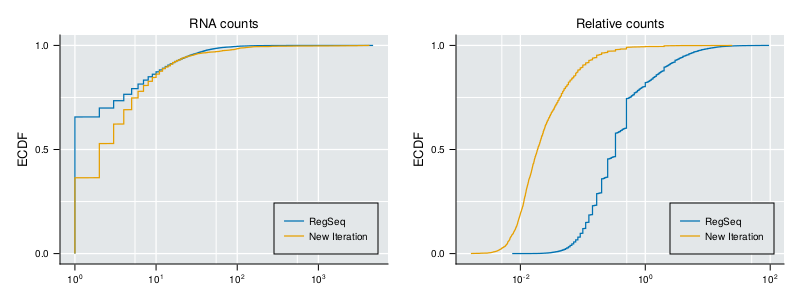

In [82]:
fig = Figure(resolution=(800, 300))
ax = Axis(fig[1, 1], xscale=log10, ylabel="ECDF", title="RNA counts")
lines!(ax, sort(df_reg.ct_1 .+1), 1/nrow(df_reg):1/nrow(df_reg):1, label="RegSeq")
lines!(ax, sort(df.ct_1 .+ 1), 1/nrow(df):1/nrow(df):1, label="New Iteration")
axislegend(ax, position=:rb)

ax = Axis(fig[1, 2], xscale=log10, ylabel="ECDF", title="Relative counts")
lines!(ax, sort((df_reg.ct_1 .+1) ./ (df_reg.ct_0 .+1)), 1/nrow(df_reg):1/nrow(df_reg):1, label="RegSeq")
lines!(ax, sort((df.ct_1 .+1) ./ (df.ct_0 .+1)), 1/nrow(df):1/nrow(df):1, label="New Iteration")
axislegend(ax, position=:rb)
fig

## Possible jackpot in RNA due to mutations in binding sites?

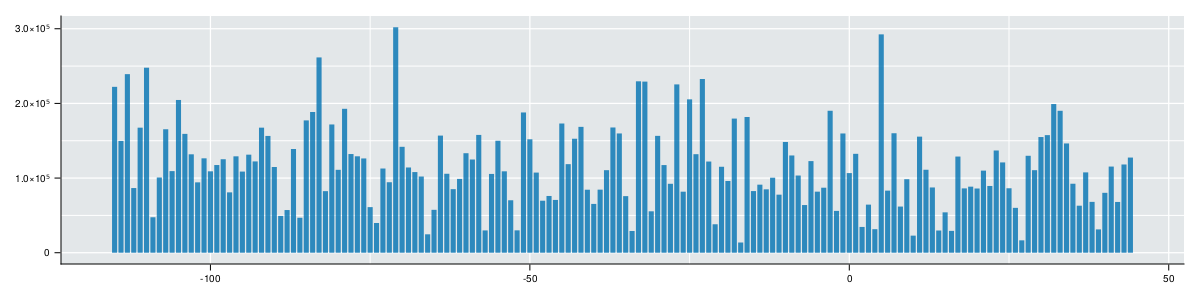

In [107]:
df = CSV.read("../../../data/LB_barcodes.csv", DataFrame)
df = df[df.name .== "rspAp", :]

insertcols!(df, 3, :int_promoter => wgregseq.analysis_utils.make_int.(df[:, :promoter]))

freq_mat = wgregseq.analysis_utils.frequency_matrix(df)
# find wild type sequence 
wt_seq = argmax(sum(freq_mat, dims=1), dims=2) |> vec
wt_seq = map(x -> x[2], wt_seq)

function is_mut(x)
    return x .!= wt_seq
end

insertcols!(df, 4, :is_mutated => is_mut.(df.int_promoter))
#df = df[df.ct_1 .> 5*10^3, :]
fig = Figure(resolution=(1200, 300))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, sum(df.is_mutated .* df.ct_1, dims=1)[1])

fig

No

## Total number of unique promoter variants

In [136]:
df = CSV.read("../../../data/LB_barcodes.csv", DataFrame)
df.promoter |> num_unique |> display
df.barcode |> num_unique |> display

159884

556807

In [137]:
df = CSV.read("../../../data/barcodes/20220514_mapping/mapped_barcodes_filtered.csv", DataFrame)
df.promoter |> num_unique |> display
df.barcode |> num_unique |> display

187306

5449828